In [1]:
from UNetKeras import UNet
import tensorflow as tf
import copy

2022-08-06 13:20:20.288455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/j/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = UNet(3, 1, 16)
batch_size = 1
img_size = (512,512)
model.build(input_shape=(batch_size,img_size,3))

2022-08-06 13:20:21.821260: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-06 13:20:21.821863: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-06 13:20:21.850770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 13:20:21.851115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-06 13:20:21.851134: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-06 13:20:21.852877: I tensorflow/stream_executor/platfor

In [13]:

graph = model.get_config()['layers']
layer_dependency = {}
layer_require_data_size = {}
sliced_data_require = {}

# It is easy to track a dependency when a list inversed
# This program shows how the data will take if we slice right before the node.
for layer_info in graph[::-1]:
    layer_name = layer_info['name']
    input_layers = layer_info['inbound_nodes']
    if len(input_layers):
        input_layers = [l[0] for l in input_layers[0]]

    # layer_input_shape = mlayer.input_shape
    # layer_output_shape = mlayer.output_shape

    # First pop myself in layer dependency
    layer_dependency.pop(layer_name, None)

    # Insert my input layers
    for input_layer in input_layers:
        input_data_shape = list(model.get_layer(name=input_layer).output_shape)
        if len(input_data_shape) == 1:
            input_data_shape = [i for i in input_data_shape[0] if i]
        elif len(input_data_shape) > 1:
            input_data_shape = [i for i in input_data_shape if i]
        else:
            input_data_shape = []
        layer_dependency[input_layer] = input_data_shape
    sliced_data_require[layer_name] = copy.deepcopy(layer_dependency)
    
sliced_data_require[model.layers[0].name] = {'input' :[*img_size,3]}

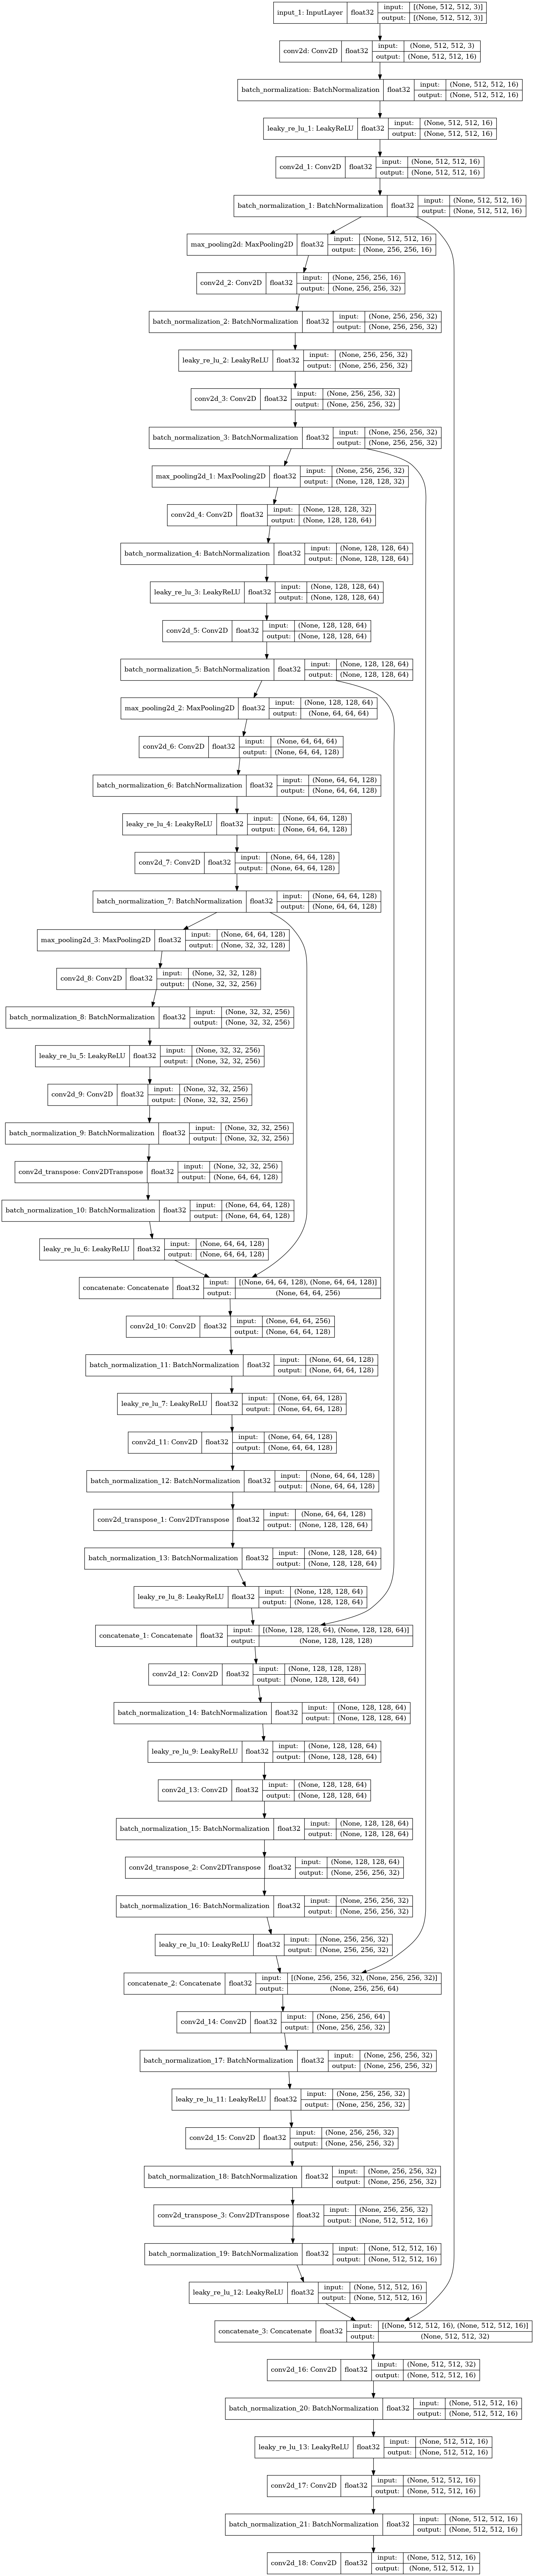

In [14]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True)

In [15]:
for layer in model.layers:
    req_data_shape = sliced_data_require[layer.name]
    data_size = 0
    for k in req_data_shape:
        tmp_sz = 1
        for r in req_data_shape[k]:
            tmp_sz *= r
        data_size += tmp_sz
    print(layer.name, data_size)

input_1 786432 {'input': [512, 512, 3]}
conv2d 786432 {'input_1': [512, 512, 3]}
batch_normalization 4194304 {'conv2d': [512, 512, 16]}
leaky_re_lu_1 4194304 {'batch_normalization': [512, 512, 16]}
conv2d_1 4194304 {'leaky_re_lu_1': [512, 512, 16]}
batch_normalization_1 4194304 {'conv2d_1': [512, 512, 16]}
max_pooling2d 4194304 {'batch_normalization_1': [512, 512, 16]}
conv2d_2 5242880 {'batch_normalization_1': [512, 512, 16], 'max_pooling2d': [256, 256, 16]}
batch_normalization_2 6291456 {'batch_normalization_1': [512, 512, 16], 'conv2d_2': [256, 256, 32]}
leaky_re_lu_2 6291456 {'batch_normalization_1': [512, 512, 16], 'batch_normalization_2': [256, 256, 32]}
conv2d_3 6291456 {'batch_normalization_1': [512, 512, 16], 'leaky_re_lu_2': [256, 256, 32]}
batch_normalization_3 6291456 {'batch_normalization_1': [512, 512, 16], 'conv2d_3': [256, 256, 32]}
max_pooling2d_1 6291456 {'batch_normalization_1': [512, 512, 16], 'batch_normalization_3': [256, 256, 32]}
conv2d_4 6815744 {'batch_normali

In [12]:
[*img_size,3]

[512, 512, 3]